In [1]:
import numpy as np
import json
import torch
import pandas as pd

npzfile = np.load("train_and_val.npz")
vocab = json.load(open("vocab.json", "r"))

In [2]:
numToWord = {value[0]: key for (key, value) in vocab.items()}


In [3]:
train = [[numToWord[i] for i in sentence if numToWord[i]!=""] for sentence in npzfile["train_x"]]
train_y = npzfile["train_y"]
val = npzfile["val_x"][:-1000]
val = [[numToWord[i] for i in sentence if numToWord[i]!=""] for sentence in val]
val_y = npzfile["val_y"][:-1000]
test = npzfile["val_x"][-1000:]
test = [[numToWord[i] for i in sentence if numToWord[i]!=""] for sentence in test]
test_y = npzfile["val_y"][-1000:]

train_tostr = [" ".join(sentence).strip() for sentence in train]
val_tostr = [" ".join(sentence).strip() for sentence in val]
test_tostr = [" ".join(sentence).strip() for sentence in test]

train_tostr[294]

'about to pass out waking up at 4:30 is not fun'

In [4]:
# pretty balanced
print("train balance ratio: ", sum(train_y!=1.0)/len(train_y))
print("val balance ratio: ", sum(val_y!=1.0)/len(val_y))
print("test balance ratio: ", sum(test_y!=1.0)/len(test_y))

train balance ratio:  0.5081475
val balance ratio:  0.5078571428571429
test balance ratio:  0.499


In [5]:
len(np.unique(npzfile["train_x"].flatten()))

8461

In [6]:
len(numToWord)

8475

In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [8]:
# Print the original sentence.
print(' Original: ', train_tostr[294])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_tostr[294]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_tostr[294])))

 Original:  about to pass out waking up at 4:30 is not fun
Tokenized:  ['about', 'to', 'pass', 'out', 'waking', 'up', 'at', '4', ':', '30', 'is', 'not', 'fun']
Token IDs:  [1164, 1106, 2789, 1149, 14047, 1146, 1120, 125, 131, 1476, 1110, 1136, 4106]


In [9]:
maxlen = -1
for sentence in train_tostr:
    maxlen = max(maxlen, len(sentence))

maxlen = int(maxlen*1.5) # in case of longer test sentence
print(maxlen)

216


In [10]:
train_token = tokenizer(train_tostr, padding=True, truncation=True, return_tensors="pt")
val_token = tokenizer(val_tostr, padding=True, truncation=True, return_tensors="pt")
test_token = tokenizer(test_tostr, padding=True, truncation=True, return_tensors="pt")


In [145]:
len(train_tostr)

400000

In [31]:
# classifying label [isPos, isNeg]
train_label = torch.tensor(train_y, dtype=torch.long)
val_label = torch.tensor(val_y, dtype=torch.long)
test_label = torch.tensor(test_y, dtype=torch.long)

In [12]:
# Print sentence 0, now as a list of IDs.
print('Original: ', train_tostr[0])
print('Token IDs:', train_token["input_ids"][0])
print('Token decoded:', tokenizer.decode(train_token["input_ids"][0]))

Original:  i'm pretty sure my mother will be picking me up from the airport
Token IDs: tensor([ 101,  178,  112,  182, 2785, 1612, 1139, 1534, 1209, 1129, 8184, 1143,
        1146, 1121, 1103, 3871,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0])
Token decoded: [CLS] i'm pretty sure my mother will be picking me up from the airport [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [59]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
train_set = TensorDataset(train_token["input_ids"], train_token["attention_mask"], train_label)
val_set = TensorDataset(val_token["input_ids"], val_token["attention_mask"], val_label)
test_set = TensorDataset(test_token["input_ids"], test_token["attention_mask"], test_label)

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [60]:
for batch in train_dataloader:
    print(batch[2])
    break

tensor([0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 0])


In [61]:
# loading pretrained BERT

from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)


# # Tell pytorch to run this model on the GPU.
model.cuda()



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [62]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [63]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [64]:
import random
from torch.nn import functional as F

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

device = torch.device("cuda")

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
#         b_input_ids = batch[0]
#         b_input_mask = batch[1]
#         b_labels = batch[2]

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        loss = F.cross_entropy(logits, b_labels)
        
#         loss, logits = model(b_input_ids, 
#                              token_type_ids=None, 
#                              attention_mask=b_input_mask, 
#                              labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            loss = F.cross_entropy(logits, b_labels)
            
#             (loss, logits) = model(b_input_ids, 
#                                    token_type_ids=None, 
#                                    attention_mask=b_input_mask,
#                                    labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  12,500.    Elapsed: 0:00:11.
  Batch    80  of  12,500.    Elapsed: 0:00:21.
  Batch   120  of  12,500.    Elapsed: 0:00:32.
  Batch   160  of  12,500.    Elapsed: 0:00:43.
  Batch   200  of  12,500.    Elapsed: 0:00:54.
  Batch   240  of  12,500.    Elapsed: 0:01:05.
  Batch   280  of  12,500.    Elapsed: 0:01:16.
  Batch   320  of  12,500.    Elapsed: 0:01:27.
  Batch   360  of  12,500.    Elapsed: 0:01:38.
  Batch   400  of  12,500.    Elapsed: 0:01:49.
  Batch   440  of  12,500.    Elapsed: 0:02:01.
  Batch   480  of  12,500.    Elapsed: 0:02:12.
  Batch   520  of  12,500.    Elapsed: 0:02:23.
  Batch   560  of  12,500.    Elapsed: 0:02:34.
  Batch   600  of  12,500.    Elapsed: 0:02:45.
  Batch   640  of  12,500.    Elapsed: 0:02:57.
  Batch   680  of  12,500.    Elapsed: 0:03:08.
  Batch   720  of  12,500.    Elapsed: 0:03:19.
  Batch   760  of  12,500.    Elapsed: 0:03:30.
  Batch   800  of  12,500.    Elapsed: 0:03:4

  Batch 6,840  of  12,500.    Elapsed: 0:31:53.
  Batch 6,880  of  12,500.    Elapsed: 0:32:04.
  Batch 6,920  of  12,500.    Elapsed: 0:32:16.
  Batch 6,960  of  12,500.    Elapsed: 0:32:27.
  Batch 7,000  of  12,500.    Elapsed: 0:32:38.
  Batch 7,040  of  12,500.    Elapsed: 0:32:49.
  Batch 7,080  of  12,500.    Elapsed: 0:33:00.
  Batch 7,120  of  12,500.    Elapsed: 0:33:12.
  Batch 7,160  of  12,500.    Elapsed: 0:33:23.
  Batch 7,200  of  12,500.    Elapsed: 0:33:34.
  Batch 7,240  of  12,500.    Elapsed: 0:33:45.
  Batch 7,280  of  12,500.    Elapsed: 0:33:56.
  Batch 7,320  of  12,500.    Elapsed: 0:34:08.
  Batch 7,360  of  12,500.    Elapsed: 0:34:19.
  Batch 7,400  of  12,500.    Elapsed: 0:34:30.
  Batch 7,440  of  12,500.    Elapsed: 0:34:41.
  Batch 7,480  of  12,500.    Elapsed: 0:34:52.
  Batch 7,520  of  12,500.    Elapsed: 0:35:04.
  Batch 7,560  of  12,500.    Elapsed: 0:35:15.
  Batch 7,600  of  12,500.    Elapsed: 0:35:26.
  Batch 7,640  of  12,500.    Elapsed: 0

  Batch 1,000  of  12,500.    Elapsed: 0:04:40.
  Batch 1,040  of  12,500.    Elapsed: 0:04:51.
  Batch 1,080  of  12,500.    Elapsed: 0:05:02.
  Batch 1,120  of  12,500.    Elapsed: 0:05:13.
  Batch 1,160  of  12,500.    Elapsed: 0:05:24.
  Batch 1,200  of  12,500.    Elapsed: 0:05:36.
  Batch 1,240  of  12,500.    Elapsed: 0:05:47.
  Batch 1,280  of  12,500.    Elapsed: 0:05:58.
  Batch 1,320  of  12,500.    Elapsed: 0:06:09.
  Batch 1,360  of  12,500.    Elapsed: 0:06:20.
  Batch 1,400  of  12,500.    Elapsed: 0:06:32.
  Batch 1,440  of  12,500.    Elapsed: 0:06:43.
  Batch 1,480  of  12,500.    Elapsed: 0:06:54.
  Batch 1,520  of  12,500.    Elapsed: 0:07:05.
  Batch 1,560  of  12,500.    Elapsed: 0:07:16.
  Batch 1,600  of  12,500.    Elapsed: 0:07:28.
  Batch 1,640  of  12,500.    Elapsed: 0:07:39.
  Batch 1,680  of  12,500.    Elapsed: 0:07:50.
  Batch 1,720  of  12,500.    Elapsed: 0:08:01.
  Batch 1,760  of  12,500.    Elapsed: 0:08:12.
  Batch 1,800  of  12,500.    Elapsed: 0

  Batch 7,840  of  12,500.    Elapsed: 0:36:35.
  Batch 7,880  of  12,500.    Elapsed: 0:36:46.
  Batch 7,920  of  12,500.    Elapsed: 0:36:57.
  Batch 7,960  of  12,500.    Elapsed: 0:37:08.
  Batch 8,000  of  12,500.    Elapsed: 0:37:19.
  Batch 8,040  of  12,500.    Elapsed: 0:37:31.
  Batch 8,080  of  12,500.    Elapsed: 0:37:42.
  Batch 8,120  of  12,500.    Elapsed: 0:37:53.
  Batch 8,160  of  12,500.    Elapsed: 0:38:04.
  Batch 8,200  of  12,500.    Elapsed: 0:38:15.
  Batch 8,240  of  12,500.    Elapsed: 0:38:27.
  Batch 8,280  of  12,500.    Elapsed: 0:38:38.
  Batch 8,320  of  12,500.    Elapsed: 0:38:49.
  Batch 8,360  of  12,500.    Elapsed: 0:39:00.
  Batch 8,400  of  12,500.    Elapsed: 0:39:11.
  Batch 8,440  of  12,500.    Elapsed: 0:39:23.
  Batch 8,480  of  12,500.    Elapsed: 0:39:34.
  Batch 8,520  of  12,500.    Elapsed: 0:39:45.
  Batch 8,560  of  12,500.    Elapsed: 0:39:56.
  Batch 8,600  of  12,500.    Elapsed: 0:40:07.
  Batch 8,640  of  12,500.    Elapsed: 0

  Batch 2,000  of  12,500.    Elapsed: 0:09:20.
  Batch 2,040  of  12,500.    Elapsed: 0:09:31.
  Batch 2,080  of  12,500.    Elapsed: 0:09:42.
  Batch 2,120  of  12,500.    Elapsed: 0:09:54.
  Batch 2,160  of  12,500.    Elapsed: 0:10:05.
  Batch 2,200  of  12,500.    Elapsed: 0:10:16.
  Batch 2,240  of  12,500.    Elapsed: 0:10:27.
  Batch 2,280  of  12,500.    Elapsed: 0:10:38.
  Batch 2,320  of  12,500.    Elapsed: 0:10:50.
  Batch 2,360  of  12,500.    Elapsed: 0:11:01.
  Batch 2,400  of  12,500.    Elapsed: 0:11:12.
  Batch 2,440  of  12,500.    Elapsed: 0:11:23.
  Batch 2,480  of  12,500.    Elapsed: 0:11:34.
  Batch 2,520  of  12,500.    Elapsed: 0:11:46.
  Batch 2,560  of  12,500.    Elapsed: 0:11:57.
  Batch 2,600  of  12,500.    Elapsed: 0:12:08.
  Batch 2,640  of  12,500.    Elapsed: 0:12:19.
  Batch 2,680  of  12,500.    Elapsed: 0:12:31.
  Batch 2,720  of  12,500.    Elapsed: 0:12:42.
  Batch 2,760  of  12,500.    Elapsed: 0:12:53.
  Batch 2,800  of  12,500.    Elapsed: 0

  Batch 8,840  of  12,500.    Elapsed: 0:41:15.
  Batch 8,880  of  12,500.    Elapsed: 0:41:26.
  Batch 8,920  of  12,500.    Elapsed: 0:41:38.
  Batch 8,960  of  12,500.    Elapsed: 0:41:49.
  Batch 9,000  of  12,500.    Elapsed: 0:42:00.
  Batch 9,040  of  12,500.    Elapsed: 0:42:11.
  Batch 9,080  of  12,500.    Elapsed: 0:42:22.
  Batch 9,120  of  12,500.    Elapsed: 0:42:33.
  Batch 9,160  of  12,500.    Elapsed: 0:42:45.
  Batch 9,200  of  12,500.    Elapsed: 0:42:56.
  Batch 9,240  of  12,500.    Elapsed: 0:43:07.
  Batch 9,280  of  12,500.    Elapsed: 0:43:18.
  Batch 9,320  of  12,500.    Elapsed: 0:43:29.
  Batch 9,360  of  12,500.    Elapsed: 0:43:41.
  Batch 9,400  of  12,500.    Elapsed: 0:43:52.
  Batch 9,440  of  12,500.    Elapsed: 0:44:03.
  Batch 9,480  of  12,500.    Elapsed: 0:44:14.
  Batch 9,520  of  12,500.    Elapsed: 0:44:25.
  Batch 9,560  of  12,500.    Elapsed: 0:44:37.
  Batch 9,600  of  12,500.    Elapsed: 0:44:48.
  Batch 9,640  of  12,500.    Elapsed: 0

  Batch 3,000  of  12,500.    Elapsed: 0:14:00.
  Batch 3,040  of  12,500.    Elapsed: 0:14:11.
  Batch 3,080  of  12,500.    Elapsed: 0:14:22.
  Batch 3,120  of  12,500.    Elapsed: 0:14:33.
  Batch 3,160  of  12,500.    Elapsed: 0:14:45.
  Batch 3,200  of  12,500.    Elapsed: 0:14:56.
  Batch 3,240  of  12,500.    Elapsed: 0:15:07.
  Batch 3,280  of  12,500.    Elapsed: 0:15:18.
  Batch 3,320  of  12,500.    Elapsed: 0:15:29.
  Batch 3,360  of  12,500.    Elapsed: 0:15:40.
  Batch 3,400  of  12,500.    Elapsed: 0:15:52.
  Batch 3,440  of  12,500.    Elapsed: 0:16:03.
  Batch 3,480  of  12,500.    Elapsed: 0:16:14.
  Batch 3,520  of  12,500.    Elapsed: 0:16:25.
  Batch 3,560  of  12,500.    Elapsed: 0:16:36.
  Batch 3,600  of  12,500.    Elapsed: 0:16:48.
  Batch 3,640  of  12,500.    Elapsed: 0:16:59.
  Batch 3,680  of  12,500.    Elapsed: 0:17:10.
  Batch 3,720  of  12,500.    Elapsed: 0:17:21.
  Batch 3,760  of  12,500.    Elapsed: 0:17:33.
  Batch 3,800  of  12,500.    Elapsed: 0

  Batch 9,840  of  12,500.    Elapsed: 0:46:54.
  Batch 9,880  of  12,500.    Elapsed: 0:47:06.
  Batch 9,920  of  12,500.    Elapsed: 0:47:17.
  Batch 9,960  of  12,500.    Elapsed: 0:47:29.
  Batch 10,000  of  12,500.    Elapsed: 0:47:41.
  Batch 10,040  of  12,500.    Elapsed: 0:47:53.
  Batch 10,080  of  12,500.    Elapsed: 0:48:04.
  Batch 10,120  of  12,500.    Elapsed: 0:48:16.
  Batch 10,160  of  12,500.    Elapsed: 0:48:28.
  Batch 10,200  of  12,500.    Elapsed: 0:48:40.
  Batch 10,240  of  12,500.    Elapsed: 0:48:51.
  Batch 10,280  of  12,500.    Elapsed: 0:49:03.
  Batch 10,320  of  12,500.    Elapsed: 0:49:15.
  Batch 10,360  of  12,500.    Elapsed: 0:49:27.
  Batch 10,400  of  12,500.    Elapsed: 0:49:39.
  Batch 10,440  of  12,500.    Elapsed: 0:49:50.
  Batch 10,480  of  12,500.    Elapsed: 0:50:02.
  Batch 10,520  of  12,500.    Elapsed: 0:50:14.
  Batch 10,560  of  12,500.    Elapsed: 0:50:26.
  Batch 10,600  of  12,500.    Elapsed: 0:50:38.
  Batch 10,640  of  12,5

In [65]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.42,0.37,0.84,0:58:18,0:02:05
2,0.34,0.36,0.85,0:58:18,0:02:05
3,0.29,0.36,0.85,0:58:20,0:02:05
4,0.25,0.39,0.85,0:59:56,0:02:05


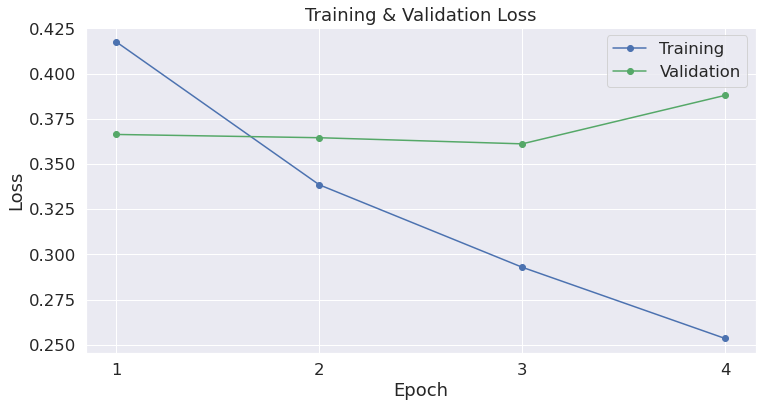

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [142]:
# Word embedding extraction
words = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday",
"Saturday", "Sunday", "orange", "apple", "banana", "fruit"]
mock_sentence_day = ['I had lunch with her last Monday', "I'll be seeing her again next Tuesday","My birthday falls on a Wednesday this year", "He was late last Thursday", "I'll leave on Friday", "He will arrive next Saturday", "She visited me last Sunday"]
mock_sentence_fruit = ["He peeled an orange", "In a small bowl, stir together the apple juice with the remaining 2 tablespoons maple syrup", "Better to use a banana peel to grow stag horn ferns", "You eat plenty of fresh fruit and vegetables"]

token_day = tokenizer(mock_sentence_day, padding=True, truncation=True, return_tensors="pt")
token_fruit = tokenizer(mock_sentence_fruit, padding=True, truncation=True, return_tensors="pt")
wordindex_day = []
wordindex_fruit = []

print('Original: ', token_day[2])
print('Token IDs:', token_day["input_ids"][2])
print('Token decoded:', tokenizer.decode(token_day["input_ids"][2]))

for tok in token_day["input_ids"]:
    for index, wid in enumerate(tok):
        if tokenizer.decode(wid) in words:
            wordindex_day.append(index)
for tok in token_fruit["input_ids"]:
    for index, wid in enumerate(tok):
        print(tokenizer.decode(wid))
        if tokenizer.decode(wid) in words:
            wordindex_fruit.append(index)



Original:  Encoding(num_tokens=11, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
Token IDs: tensor([ 101, 1422, 5913, 4887, 1113,  170, 9031, 1142, 1214,  102,    0])
Token decoded: [CLS] My birthday falls on a Wednesday this year [SEP] [PAD]
[CLS]
He
peeled
an
orange
[SEP]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[CLS]
In
a
small
bowl
,
stir
together
the
apple
juice
with
the
remaining
2
tables
##poon
##s
maple
syrup
[SEP]
[CLS]
Better
to
use
a
banana
p
##eel
to
grow
s
##tag
horn
f
##ern
##s
[SEP]
[PAD]
[PAD]
[PAD]
[PAD]
[CLS]
You
eat
plenty
of
fresh
fruit
and
vegetables
[SEP]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]


In [114]:
model.eval()
with torch.no_grad():
    outputs = model(token_day["input_ids"].to(device), token_day["attention_mask"].to(device))
with torch.no_grad():
    outputs_fruit = model(token_fruit["input_ids"].to(device), token_fruit["attention_mask"].to(device))

In [115]:
hidden_states = outputs.hidden_states

print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0
print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0
print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0
print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat_day = []

# Using only the last four layers
for i in range(0, 7):
    token_vecs_cat_day.append(torch.cat((hidden_states[-1][i][wordindex_day[i]], hidden_states[-2][i][wordindex_day[i]], hidden_states[-3][i][wordindex_day[i]], hidden_states[-4][i][wordindex_day[i]]), dim=0))
print ('Shape is: %d x %d' % (len(token_vecs_cat_day), len(token_vecs_cat_day[0])))





Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 7
Number of tokens: 11
Number of hidden units: 768
Shape is: 7 x 3072


In [117]:
hidden_states = outputs_fruit.hidden_states

print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0
print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0
print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0
print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

#Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat_fruit = []

# Using only the last four layers
for i in range(0, 4):
    token_vecs_cat_fruit.append(torch.cat((hidden_states[-1][i][wordindex_fruit[i]], hidden_states[-2][i][wordindex_fruit[i]], hidden_states[-3][i][wordindex_fruit[i]], hidden_states[-4][i][wordindex_fruit[i]]), dim=0))
print ('Shape is: %d x %d' % (len(token_vecs_cat_fruit), len(token_vecs_cat_fruit[0])))



Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 4
Number of tokens: 21
Number of hidden units: 768
Shape is: 4 x 3072


In [132]:
embedding = []

for tensor in token_vecs_cat_day:
    embedding.append(tensor.cpu().numpy())
for tensor in token_vecs_cat_fruit:
    embedding.append(tensor.cpu().numpy())
    
embedding = np.array(embedding)
embedding.shape

(11, 3072)

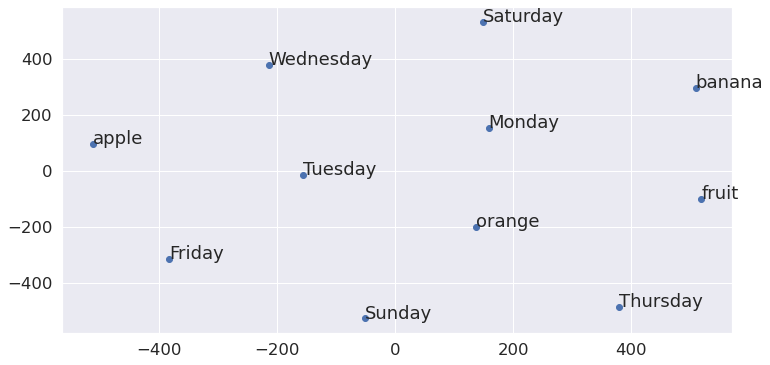

In [143]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, random_state = 0)
tsne_embed = tsne.fit_transform(embedding)
tsne_embed.shape

x = tsne_embed[:,0]
y = tsne_embed[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y)
for i, txt in enumerate(words):
    ax.annotate(txt, (x[i], y[i]))
plt.show()